# Spark RDD

* Last updated 20181112MON1130 20171218 20170515 20161125

## S.1 학습내용

### S.1.1 목표

* 파일, JSON 등에서 RDD를 생성할 수 있다.
* map-reduce 등 RDD API를 사용하여 데이터를 변환하고, 분석할 수 있다.
* 텍스트데이터를 단어 빈도, word vector로 변환할 수 있다.

### S.1.2 목차

* S.2 Data를 사용하는 API 
* S.3 SparkSession
* S.3.1 Spark 2.0 vs 1.6 
* S.3.2 SparkContext
* S.3.3 IPython Notebook에서 SparkSession 생성하기
* S.4 RDD 소개
* S.5 RDD 생성
* S.6 RDD API 
* S.6.1 비슷한 Python 함수
* S.6.2 RDD 사용하기
* 5.6.3 Pair RDD
* S.7 spark-submit

### S.1.3 문제

* 문제 S-1: Hello Spark - 환경설정을 읽어 클라이언트를 생성하기.
* 문제 S-2: RDD를 사용하여 word count를 계산하고 그래프 그리기.
* 문제 S-3: 성적 합계 및 평균.
* 문제 S-4: 서울시 지하철호선별 승차인원 평균 구하기.
* 문제 S-3: RDD를 사용하여 word vector를 생성하기.

## S.2 클라이언트 생성

### S.3.1 SparkSession

#### Spark 2.x

**Spark 2.0부터는 SparkSession을 시작점**으로 개별적인 Context를 모두 **통합**해서 사용한다.
SparkSession은 빅데이터를 처리하기 위해 구성된 **Spark 클러스터에 대한 클라이언트**와 같은 역할을 하며, 이를 통해 모든 기능을 사용한다.
따라서 클러스터 매니저로부터 에서 CPU, 메모리, 하드웨어 등 시스템 자원을 배분받아서 필요한 작업을 수행하게 된다.

#### 이전 Spark 1.x
참고로 **Spark 2.0 이전에는 SparkContext를 먼저 만들고** 이를 통해 다른 Context를 사용했다. 아래에서 보듯이 Spark 1.x에서는 **SparkContext를 직접 생성**하고, **이를 통해 SQLContext, HiveContext도 생성**하여 사용했다. 이런 방식은 2.x에서도 호환되므로 그대로 사용할 수도 있지만, **SparkSession으로 통합**되었다.

```python
# 버전 1.x
import pyspark
conf=pyspark.SparkConf()
conf = pyspark.SparkConf().setAppName("myAppName")
sc = pyspark.SparkContext(conf=conf)  #SparkContext를 직접 생성한다.
sqlContext = SQLContext(sc)           #SparkContext를 넣어서 SQLContext를 생성
```

Context는 아래와 같이 Spark 서버를 사용하기 위한 클라이언트라고 생각하자.

Context 구분 | 설명 | 2.0의 사용 예 | 1.x의 사용 예
----------|----------|----------|----------
SparkContext | RDD를 사용하는 Context | spark.SparkContext | SparkContext()
StreamingContext | 향후 제공 | |
SQLContext | Spark SQL, DataFrame | spark.sql | SQLContext(SparkContext)
HiveContext | HiveQL, DataFrame | spark.sql | HiveContext(SparkContext)

### S.3.2 IPython Notebook에서 SparkSession 생성하기

* Spark에서 pyspark shell을 제공하고 있다.
* 이 강의에서는 ipython notebook에서 pyspark를 사용하기로 한다.


## 문제 S-1: Hello Spark, 환경설정을 읽어 클라이언트 생성하기.

Spark를 별도로 설치하지 않고 Databricks를 사용할 수도 있다 (https://community.cloud.databricks.com/) 이 사이트에서는 SparkSession을 미리 생성해 주어서 굳이 SparkSession을 생성하지 않아도 된다. 또는 PySpark를 사용해도 마찬가지 이다. 필요한 SparkSession을 이미 만들어 주어서 번거롭게 만들어 사용하지 않아도 된다.
여기서는 Notebook에서 사용하기 위해 SparkSession을 생성하기로 한다.

### 경로 및 라이브러리 추가

Spark가 설치된 디렉토리를 SPARK_HOME으로 설정하고, 또한 실행에 필요한 라이브러리를 추가한다.
보통 라이브러리 경로는 디렉토리를 지정하게 되지만, **zip**파일도 경로로 추가할 수 있다.

설정 항목 | 설명
----------|----------
SPARK_HOME | Spark가 설치된 경로이다.
PYTHONPATH | sys.path.insert()를 사용하여 'PYTHONPATH'를 수정한다. pyspark.zip, py4j-0.10.x-src.zip를 추가 (버전은 수정해야 함)

In [1]:
import os
import sys

#home=os.path.expanduser("~") # HOME이 설정되어 있지 않으면 expanduser('~')를 사용한다.
os.environ["SPARK_HOME"]=os.path.join(os.environ['HOME'],'Downloads','spark-2.0.0-bin-hadoop2.7')
os.environ["PYLIB"]=os.path.join(os.environ["SPARK_HOME"],'python','lib')
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'py4j-0.10.1-src.zip'))
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'pyspark.zip'))

Python 라이브러리 경로가 방금 추가한 두 개의 zip파일이 잡혀있는 것을 볼 수 있다.

In [2]:
for i in sys.path:
    print i

/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/python/lib/pyspark.zip
/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/python/lib/py4j-0.10.1-src.zip

/usr/lib/python2.7
/usr/lib/python2.7/plat-x86_64-linux-gnu
/usr/lib/python2.7/lib-tk
/usr/lib/python2.7/lib-old
/usr/lib/python2.7/lib-dynload
/home/jsl/.local/lib/python2.7/site-packages
/usr/local/lib/python2.7/dist-packages
/usr/lib/python2.7/dist-packages
/usr/lib/python2.7/dist-packages/PILcompat
/usr/lib/python2.7/dist-packages/gtk-2.0
/usr/lib/python2.7/dist-packages/ubuntu-sso-client
/usr/local/lib/python2.7/dist-packages/IPython/extensions
/home/jsl/.ipython


### SparkSession 생성

SparkSession을 생성해 보자. SparkSesion은 sql 모듈로 **'pyspark.sql.SparkSession'**을 클라이언트로 사용한다.
SparkSession은 **builder.getOrCreate()** 함수를 호출하여, 기존의 session 또는 새로 생성하여 사용한다. 함수 **getOrCreate()** 함수는 **singleton 패턴**으로 한 번에 하나의 세션만이 존재하도록 한다.
SparkSession을 종료하려면 stop() 함수를 호출한다.

```python
spark = pyspark.sql.SparkSession.builder.getOrCreate()
spark.stop()
```

In [3]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

### spark-warehouse

spark-warehouse는 내부적으로 사용되는 디렉토리로서, Derby 데이터베이스 관련 파일을 저장하게 된다.
이 디렉토리는 Spark를 실행하면 작업 디렉토리 아래 자동으로 생성된다.
또는 ```/conf/hive-site.xml``` 파일에 spark.sql.warehouse.dir를 설정해도 된다.
또는 실행하면서 추가할 수도 있다.

```python
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config("spark.sql.warehouse.dir", "C:/Users/jsl/myTemp")\
    .getOrCreate()
```

spark-warehouse 디렉토리는 conf.get() 함수로 알아볼 수 있다. 다음에서 보듯이, 현재 작업디렉토리 밑에 spark-warehous가 만들어졌다는 의미이다.

In [4]:
spark.conf.get('spark.sql.warehouse.dir')

u'file:${system:user.dir}/spark-warehouse'

몇 가지 설정을 확인해 보자.
설치디렉토리 아래 ```conf/```에 있는 spark-defaults.conf와 같은 설정파일에 자신에게 필요한 설정을 해 놓으면 된다.

In [5]:
print spark.version
print spark.conf.get('spark.app.name')
print spark.conf.get('spark.master')
print spark.conf.get('spark.driver.host')

2.0.0
pyspark-shell
local[*]
117.16.44.45


Spark를 실행하면서 라이브러리를 설정해야 할 필요도 생겨나게 된다. 다음은 mongo, graphframes, csv 등의 라이브러리가 설정되어 있는 내용을 보여주고 있다. 라이브러리는 https://spark-packages.org 를 방문해서 찾아서 사용하면 된다. 실제로 설치하지 않고, 명명규칙에 따라, maven에서 하는 것과 같이, 콜론으로 구분해, 패키지명과 라이브러리를 버전정보와 같이 적어주면 된다.

In [7]:
print spark.conf.get('spark.jars.packages')

graphframes:graphframes:0.4.0-spark2.0-s_2.11,org.mongodb.spark:mongo-spark-connector_2.10:2.0.0,com.databricks:spark-csv_2.11:1.5.0


## S.2 데이터 구조

Spark에서는 RDD, Dataframe, DataSet와 같은 세 가지 데이터구조를 제공하고 있다. **RDD**는 Spark 1.0부터 사용되었고, 이를 기반으로 다른 데이터구조가 만들어졌다. 다음으로 **Dataframe**은 버전 1.3에서 제공되어 많이 쓰이고 있다. 마지막으로 **DataSet**은 그 후 1.6부터 제공하고 있다. 이 가운데 **RDD API에 대한 지원은 축소**되고 있다.

데이터구조 | 도입된 spark version | 설명
---------|---------|---------
**RDD** | Spark 1.0 | **비구조적**, schema free, low-level
**Dataframe** | 1.3 | **구조적**, schema를 가진다. Dataset[Row]와 같은 의미로, 타잎을 강제하지 않는다.
**Dataset** | 1.6 | 자바의 Generic과 같이 Dataset[T]으로 '타잎'을 강제하는 형식이다. Scala and Java에서 사용한다. Python loosely-typed이므로 사용하지 않는다.


* RDD는 데이터가 **비구조적**인 경우 사용하기 적합하다. 모델schema를 정하지 않고 사용할 수 있다. 반면에 DataFrame과 DataSet은 데이터가 schema와 데이터타잎을 가진 **구조적**인 경우 사용한다.
* Spark의 RDD, DataFrame 모두 immutable이라 일단 생성되고 나면 원본을 수정할 수 없다.
* Spark의 데이터는 모두 **lazy**, 실제 transformation을 action까지 연기한다. **변환할 때마다 실제 변환이 일어나면 그 결과가 메모리에 저장되는 비효율성**을 막기 위해, **action이 실행되는 경우, 계산이 이루어지고, 실제 메모리를 사용**한다. RDD의 경우, action이 실행될 때마다 재계산이 이루어지는 것을 막기 위해 persist (or cache)함수를 사용할 수 있다.


## S.4 RDD 소개

RDD (Resilient Distributed Dataset)는 그 줄임말에서 알 수 있듯이 **데이터를 저장하고 있는 DataSet**이며, 여러 컴퓨터에 **분산**해서 사용해서 사용할 수 있다는 점이 특징이다.
* Resilient - 작업이 실패하지 않도록 fault tolerent, 즉 어느 한 노드에서 작업이 실패하면 다른 노드에서 실행
* Distributed - 클라스터로 구성된 여러 노드에 분산해서 처리
* Dataset - 데이터 구조

RDD는 Python List, 파일, hdfs 등 다양한 자료에서 생성할 수 있고, 생성된 자료는 수정할 수 없는 read-only이다.

## S.5 RDD 생성

RDD는 **sparkContext**로부터 만들어 진다. 1) 외부 파일 또는 2) 배열과 같은 자료구조에서 읽어서 생성한다.

생성 방법 | 설명 | 함수
----------|----------|----------
외부에서 읽기 | 파일, HDFS, HBase 등 | ```textFile("mydir/")```<br>```textFile("mydir/*.txt")```<br>```textFile("mydir/*.gz")```<br>```Hadoop InputFormat```
내부에서 읽기 | Pytho list에서 생성 | parallelize()


### List에서 RDD 생성하기

Python list에서 RDD를 생성할 수 있다.
sparkcontext.parallelize()함수를 사용하여 list로부터 RDD를 생성할 수 있다.

In [8]:
myList=[1,2,3,4,5,6,7]
myRdd1 = spark.sparkContext.parallelize(myList)

In [9]:
myRdd1.take(3)

[1, 2, 3]

### 파일에서 RDD 생성하기

파일에서 직접 RDD를 생성해 본다.
현재 작업 디렉토리 아래에 **'data/' 디렉토리**를 만들고 아래 파일을 생성한다.
파일 내용은 wikipedia에서 Apache spark를 검색한 후 첫 문단을 복사해서 가져 왔다.
일부러 3째줄은 한글, 4째 줄은 같은 단어를 반복해서 추가했다.

In [13]:
%%writefile data/ds_spark_wiki.txt
Wikipedia
Apache Spark is an open source cluster computing framework.
아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.
Apache Spark Apache Spark Apache Spark Apache Spark
아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크
Originally developed at the University of California, Berkeley's AMPLab,
the Spark codebase was later donated to the Apache Software Foundation,
which has maintained it since.
Spark provides an interface for programming entire clusters with
implicit data parallelism and fault-tolerance.

Overwriting data/ds_spark_wiki.txt


In [10]:
myRdd2=spark.sparkContext\
    .textFile(os.path.join("data","ds_spark_wiki.txt"))

In [11]:
myRdd2.first()

u'Wikipedia'

In [9]:
%%writefile data/ds_bigdata_wiki.txt
활용사례 및 의의[편집]
정치 및 사회[편집]
2008년 미국 대통령 선거[편집]
2008년 미국 대통령 선거에서 버락 오바마 미국 대통령 후보는 다양한 형태의 유권자 데이터베이스를 확보하여 이를 분석, 활용한 '유권자 맞춤형 선거 전략'을 전개했다. 당시 오바마 캠프는 인종, 종교, 나이, 가구형태, 소비수준과 같은 기본 인적 사항으로 유권자를 분류하는 것을 넘어서서 과거 투표 여부, 구독하는 잡지, 마시는 음료 등 유권자 성향까지 전화나 개별 방문을 또는 소셜 미디어를 통해 유권자 정보를 수집하였다. 수집된 데이터는 오바마 캠프 본부로 전송되어 유권자 데이터베이스를 온라인으로 통합관리하는 ‘보트빌더(VoteBuilder.com)’시스템의 도움으로 유권자 성향 분석, 미결정 유권자 선별 , 유권자에 대한 예측을 해나갔다. 이를 바탕으로‘유권자 지도’를 작성한 뒤 ‘유권자 맞춤형 선거 전략’을 전개하는 등 오바마 캠프는 비용 대비 효과적인 선거를 치를 수 있었다.

대한민국 제19대 총선[편집]
중앙선거관리위원회는 대한민국 제19대 총선부터 소셜 네트워크 등 인터넷 상의 선거 운동을 상시 허용하였다.[15] 이에 소셜 미디어 상에서 선거 관련 데이터는 증폭되었으며, 2010년 대한민국 제5회 지방 선거 및 2011년 대한민국 재보궐선거에서 소셜 네트워크 서비스의 중요성을 확인한 정당들 또한 SNS 역량 지수를 공천 심사에 반영하는 등[16] 소셜 네트워크 활용에 주목했다. 이 가운데 여론 조사 기관들은 기존 여론조사 방식으로 예측한 2010년 제5회 지방 선거 및 2011년 재보궐선거의 여론조사 결과와 실제 투표 결과와의 큰 차이를 보완하고자 빅 데이터 기술을 활용한 SNS 여론 분석을 시행했다. 그러나 SNS 이용자의 대다수가 수도권 20~30대에 쏠려 있기에[17], 빅 데이터를 이용한 대한민국 제19대 총선에 대한 SNS 분석은 수도권으로 한정되어 일치하는 한계를 드러내기도 하였다.

경제 및 경영[편집]
아마존닷컴의 추천 상품 표시 / 구글 및 페이스북의 맞춤형 광고[편집]
아마존닷컴은 모든 고객들의 구매 내역을 데이터베이스에 기록하고, 이 기록을 분석해 소비자의 소비 취향과 관심사를 파악한다.[18] 이런 빅 데이터의 활용을 통해 아마존은 고객별로 '추천 상품(레코멘데이션)'을 표시한다. 고객 한사람 한사람의 취미나 독서 경향을 찾아 그와 일치한다고 생각되는 상품을 메일, 홈 페이지상에서 중점적으로 고객 한사람 한사람에게 자동적으로 제시하는 것이다.[19] 아마존닷컴의 추천 상품 표시와 같은 방식으로 구글 및 페이스북도 이용자의 검색 조건, 나아가 사진과 동영상 같은 비정형 데이터 사용을 즉각 처리하여 이용자에게 맞춤형 광고를 제공하는 등 빅데이터의 활용을 증대시키고 있다.

문화[편집]
MLB (메이저 리그 베이스볼)의 머니볼 이론 및 데이터 야구[편집]
머니볼 이론이란 경기 데이터를 철저하게 분석해 오직 데이터를 기반으로 적재적소에 선수들을 배치해 승률을 높인다는 게임 이론이다.[20] 이는 미국 메이저 리그 베이스볼 오클랜드 어슬레틱스의 구단장 빌리 빈이 리그 전체 25위에 해당하는 낮은 구단 지원금 속에서도 최소비용으로 최대효과를 거둔 상황에서 유래되었다. 빌리 빈은 하치해 최하위에 그치던 팀을 4년 연속 포스트시즌에 진출시키고 메이저 리그 최초로 20연승이라는 신기록을 세우도록 탈바꿈 시켰다. 미국 월스트리트 저널은 미국 경제에 큰 영향을 끼치는 파워 엘리트 30인에 워렌 버핏, 앨런 그린스펀과 함께 빌리 빈을 선정[21] 하는 등 머니볼 이론은 경영, 금융 분야에서도 주목받았다. 최근 들어서 과학기술 및 카메라 기술의 발달로 더욱 정교한 데이터의 수집이 가능해졌으며 투구의 궤적 및 투수의 그립, 타구 방향, 야수의 움직임까지 잡아낼 수 있게 되었다. 이처럼 기존의 정형 데이터뿐만 아닌 비정형 데이터의 수집과 분석, 활용을 통해 최근 야구경기에서 빅 데이터의 중요성은 더욱 커지고 있다.

선수의 인기만을 쫓는 것이 아니라 팀별 승률이나 선수의 성적을 나타내는 수치와 야구를 관전한다면 그 재미는 배가된다. '출루율'은 타율로 인정되지 않는 볼넷을 포함하여 타자가 성공적으로 베이스를 밟은 횟수의 비율, '장타율'은 타수마다 밟은 총 베이스를 계산해서 타격력이 얼마나 강한지를 나타내는 비율이다.

출루율과 장타율 못지 않게 '타수'는 한두 경기에서 낸 성적이 아닌, 수천 번의 타석에 들어 좋은 성적을 만들어낸 선수를 선별하기 위한 기초 통계자료이다. 이처럼 한 선수의 타율에서 팀의 역대 시리즈 전적까지 모든 것을 숫자로 표현할 수 있다고 해서 야구를 '통계의 스포츠'라고 부르기도 한다. 야구뿐만 아니라 생활 곳곳에서 활용되는 통계는 복잡한 상황과 설명을 간단한 숫자로 바꿔주는 매우 강력한 도구이다.[22]

'프로파일링'과 '빅데이터' 기법을 활용한 프로그램 MBC <프로파일링>[편집]
방송에는 19세 소년의 살인 심리를 파헤친 '용인살인사건의 재구성', 강남 3구 초등학교 85곳의 학업성취도평가 성적과 주변 아파트 매매가의 상관관계를 빅데이터(디지털 환경에서 발생한 방대한 규모의 데이터)를 통해 분석한 '강남, 부자일수록 공부를 잘할까'[23]

2014년 FIFA 월드컵 독일 우승과 '빅데이터'[편집]
브라질에서 개최된 2014년 FIFA 월드컵에서 독일은 준결승에서 개최국인 브라질을 7:1로 꺾고, 결승에서 아르헨티나와 연장전까지 가는 접전 끝에 1:0으로 승리를 거두었다. 무패행진으로 우승을 차지한 독일 국가대표팀의 우승의 배경에는 '빅데이터'가 있었다.

독일 국가대표팀은 SAP와 협업하여 훈련과 실전 경기에 'SAP 매치 인사이트'를 도입했다. SAP 매치 인사이트란 선수들에게 부착된 센서를 통해 운동량, 순간속도, 심박수, 슈팅동작 등 방대한 비정형 데이터를 수집, 분석한 결과를 감독과 코치의 태블릿PC로 전송하여 그들이 데이터를 기반으로 전술을 짜도록 도와주는 솔루션이다. 기존에 감독의 경험이나 주관적 판단으로 결정되는 전략과는 달리, SAP 매치 인사이트를 통해 이루어지는 분석은 선수들에 대한 분석 뿐만 아니라 상대팀 전력, 강점, 약점 등 종합적인 분석을 통해 좀 더 과학적인 전략을 수립할 수 있다. 정보 수집에 쓰이는 센서 1개가 1분에 만들어내는 데이터는 총 12000여개로 독일 국가대표팀은 선수당 4개(골키퍼는 양 손목을 포함해 6개)의 센서를 부착했고, 90분 경기동안 한 선수당 약 432만개, 팀 전체로 약 4968만개의 데이터를 수집했다고 한다.월드컵8강 獨 전차군단 비밀병기는 '빅데이터'

과학기술 및 활용[편집]
통계학[편집]
데이터 마이닝이란 기존 데이터베이스 관리도구의 데이터 수집, 저장, 관리, 분석의 역량을 넘어서는 대량의 정형 또는 비정형 데이터 집합 및 이러한 데이터로부터 가치를 추출하고 결과를 분석하는 기술로, 수집되는 ‘빅 데이터’를 보완하고 마케팅, 시청률조사, 경영 등으로부터 체계화돼 분류, 예측, 연관분석 등의 데이터 마이닝을 거쳐 통계학적으로 결과를 도출해 내고 있다.[24][25]

대한민국에서는 2000년부터 정보통신부의 산하단체로 사단법인 한국BI데이터마이닝학회가 설립되어 데이터 마이닝에 관한 학술과 기술을 발전, 보급, 응용하고 있다. ‎또한 국내ㆍ외 통계분야에서 서서히 빅 데이터 활용에 대한 관심과 필요성이 커지고 있는 가운데 국가통계 업무를 계획하고 방대한 통계자료를 처리하는 국가기관인 통계청이 빅 데이터를 연구하고 활용방안을 모색하기 위한 '빅 데이터 연구회'를 발족하였다.[26] 하지만 업계에 따르면, 미국과 영국, 일본 등 선진국들은 이미 빅 데이터를 다각적으로 분석해 조직의 전략방향을 제시하는 데이터과학자 양성에 사활을 걸고 있다. 그러나 한국은 정부와 일부 기업이 데이터과학자 양성을 위한 프로그램을 진행 중에 있어 아직 걸음마 단계인 것으로 알려져 있다.[27]

생물정보학[편집]
최근 생물학에서 DNA, RNA, 단백질 서열 및 유전자들의 발현과 조절에 대한 데이터의 양이 급격히 증가했고 이에 따라 이 빅 데이터를 활용한 생명의 이해에 관한 논의가 진행되고 있다.

보건의료[편집]
국민건강보험공단은 가입자의 자격·보험료, 진료·투약내용, 건강검진 결과 및 생활습관 정보 등 2조1천억건, 92테라바이트의 빅데이터를 보유하고 있고, 한편, 건강보험심사평가원은 진료내역, 투약내용(의약품 안심서비스), 의약품 유통 등의 2조2천억건, 89테라바이트의 빅데이터를 보유하고 있으며, 경제협력개발기구(OECD)는 한국의 건강보험 빅데이터 순위가 2위라고 발표했었다. 건보공단과 심평원은 빅데이터를 민간에 널리 알리고 더 많이 개방하고 있다. (연합뉴스 2016.6.14 인터넷뉴스 참조)

빅 데이터를 활용하면 미국 의료부문은 연간 3,300 억 달러(미 정부 의료 예산의 약 8%에 해당하는 규모)의 직간접적인 비용 절감 효과를 보일 것으로 전망된다.[28] 특히 임상분야에서는 의료기관 별 진료방법, 효능, 비용 데이터를 분석하여 보다 효과적인 진료방법을 파악하고 환자 데이터를 온라인 플랫폼화하여 의료협회 간 데이터 공유로 치료 효과를 제고하며 공중보건 영역에선 전국의 의료 데이터를 연계하여 전염병 발생과 같은 긴박한 순간에 빠른 의사결정을 가능케 할 전망이다.[29]

한편, 의료 분야에서 빅 데이터가 효과를 발휘하기 위해서는 대량의 의료정보 수집이 필수적이기 때문에, 개인정보의 보호와 빅 데이터 활용이라는 두 가지 가치가 상충하게 되된다. 따라서, 의료 분야에서 빅 데이터의 활용과 보급을 위해서는 이러한 문제에 대한 가이드라인 마련이 필요한 상태이다.[30]

기업 경영[편집]
대규모의 다양한 데이터를 활용한 '빅데이터 경영'이 주목받으면서 데이터 품질을 높이고 방대한 데이터의 처리를 돕는 데이터 통합(Data Integration)의 중요성이 부각되고 있다.

데이터 통합(DI)은 데이터의 추출, 변환, 적재를 위한 ETL 솔루션이 핵심인데 ETL 솔루션을 활용하면 일일이 수많은 데이터를 기업 데이터 포맷으로 코딩하지 않아도 되고 데이터 품질을 제고할 수 있기 때문에 DI는 빅데이터 환경에 꼭 필요한 데이터 솔루션으로 평가받고 있는 단계까지 진입되었다.

한편 비즈니스 인텔리전스(Business Intelligence, BI)보다 진일보한 빅데이터 분석 방법이 비즈니스 애널리틱스(Business analytics, BA)인데 고급분석 범주에 있는 BA는 기본적으로 BI를 포함하면서도 미래 예측 기능과 통계분석, 확률 분석 등을 포함해 최적의 데이터 기반 의사결정을 가능케 하는 것으로 평가받고 있기도 하다.[31]

마케팅[편집]
인터넷으로 시작해서 인터넷으로 마감하는 생활, 스마트폰을 이용해 정보를 검색하고 쇼핑도하고 SNS를 이용해서 실시간으로 글을 남기는 등의 다양하게 인터넷을 이용하는 동안 남는 흔적같은 모인 데이터들을 분석하면 개인의 생활 패턴, 소비성향 등을 예측할 수 있고 기업들은 이런 데이터를 통해서 소비자가 원하는 것들을 미리 예측할 수 있다. 빅 데이터가 마케팅 자료로 활용되는 사례이다.[31]

기상정보[편집]
한반도 전역의 기상관측정보를 활용해 일기예보와 각종 기상특보 등 국가 기상서비스를 제공하고 있는 기상청은 정밀한 기상예측을 위한 분석 과정에서 발생하는 데이터 폭증에 대응하고자 빅데이터 저장시스템의 도입을 추진하였다.

대다수 스토리지 기업들의 솔루션을 검토한 끝에 한국 IBM의 고성능 대용량 파일공유시스템(General Parallel File System, 이하 GPFS)을 적용한 스토리지 시스템을 선택하였다고 밝혔다.

한국IBM이 기상청에 제공한 GPFS 기반의 빅데이터 저장시스템은 IBM 시스템 스토리지 제품군, 시스템 x서버 제품군과 고속 네트워킹 랙스위치(RackSwitch) 등이 통합돼 있는 시스템이다.[31]

보안관리[편집]
보안관리는 빅데이터 환경을 이용해 성장과 기술 발전을 동시에 이루는 분야로 분리한다. 클라우드 및 모바일 환경으로 접어들면서 물리/가상화 IT 시스템의 복잡성이 더욱 높아지고 있어 유무선 네트워크, 프라이빗/퍼블릭 클라우드, 모바일 애플리케이션과 기기관리 등 IT 시스템 전반에서 대대적인 변화가 예상되고 있어 막대한 양의 보안관리가 중요한 요소로 현실화되고 있다.[32]

구글 번역[편집]
구글에서 제공하는 자동 번역 서비스인 구글 번역은 빅 데이터를 활용한다. 지난 40년 간 컴퓨터 회사 IBM의 자동 번역 프로그램 개발은 컴퓨터가 명사, 형용사, 동사 등 단어와 어문의 문법적 구조를 인식하여 번역하는 방식으로 이뤄졌다. 이와 달리 2006년 구글은 수억 건의 문장과 번역문을 데이터베이스화하여 번역시 유사한 문장과 어구를 기존에 축적된 데이터를 바탕으로 추론해 나가는 통계적 기법을 개발하였다. 캐나다 의회의 수백만 건의 문서를 활용하여 영어-불어 자동번역 시스템개발을 시도한 IBM의 자동 번역 프로그램은 실패한 반면 구글은 수억 건의 자료를 활용하여 전 세계 58개 언어 간의 자동번역 프로그램 개발에 성공하였다. 이러한 사례로 미루어 볼 때, 데이터 양의 측면에서의 엄청난 차이가 두 기업의 자동 번역 프로그램의 번역의 질과 정확도를 결정했으며, 나아가 프로젝트의 성패를 좌우했다고 볼 수 있다.[31]



Writing data/ds_bigdata_wiki.txt


In [12]:
myRdd3=spark.sparkContext\
    .textFile(os.path.join("data","ds_bigdata_wiki.txt"))

In [13]:
for i in myRdd3.take(2):
    print i

활용사례 및 의의[편집]
정치 및 사회[편집]


#### RDD와 Spark Dataframe를 만드는 함수는 서로 다르다

다음에 배우겠지만, file에서 읽는 방식이 RDD와 Dataframe이 서로 다르다.
RDD는 sparkContext.textFile(), Dataframe은 read.text()을 사용한다.

구분 | 설명
-----|-----
SparkSession.sparkContext.textFile() | **'SparkContext'를 사용하므로 RDD를 생성**한다.
SparkSession.read.text() | **DataFrame을 생성**한다.

In [10]:
import os
myDf=spark.read.text(os.path.join("data", "ds_spark_wiki.txt"))
print myDf.first()

Row(value=u'Wikipedia')


In [9]:
print type(myDf)

<class 'pyspark.sql.dataframe.DataFrame'>


#### csv에서 RDD 생성하기

csv 파일을 읽어서 RDD를 생성해 보자.

In [ ]:
%%writefile ./data/ds_spark_2cols.csv
35, 2
40, 27
12, 38
15, 31
21, 1
14, 19
46, 1
10, 34
28, 3
48, 1
16, 2
30, 3
32, 2
48, 1
31, 2
22, 1
12, 3
39, 29
19, 37
25, 2

RDD를 파일에서 읽어 생성하면, 전체가 하나의 리스트가 된다.
아래에서 보듯이 파일의 각 라인이 묶여서 리스트의 한 요소로 만들어진다.

In [11]:
myRdd4 = spark.sparkContext\
    .textFile(os.path.join("data","ds_spark_2cols.csv"))
myRdd4.take(5)

[u'35, 2', u'40, 27', u'12, 38', u'15, 31', u'21, 1']

2차원 리스트로 만드려면, map()함수를 사용한다.
```python
모든 줄을 반복:
    한 줄line을 읽는다.
    줄line을 컴마(,)로 분리한다.
    줄line을 리스트로 만든다.
```

In [12]:
myRdd5 = myRdd4.map(lambda line: line.split(','))
myRdd5.take(5)

[[u'35', u' 2'],
 [u'40', u' 27'],
 [u'12', u' 38'],
 [u'15', u' 31'],
 [u'21', u' 1']]

## S.6 RDD API

앞서 RDD를 생성하여 보았다.
이제는 RDD라는 데이터구조에서 데이터를 읽고 변환하고 분석하여 보자.
RDD는 **데이터 변환Transformations**, **연산Actions**으로 구분할 수 있다.
다음에 배우게 될 **Dataframe**의 **Transformer**, **Estimator**와 비교될 수 있다.

### 변환 **transformations**

**lazy연산**을 한다. 즉, 실제 변환은 action이 수행되는 시점까지 늦추어져서 이루어진다.
변환 결과는 RDD 또는 seq(RDD)로 만들어진다.

함수 | 설명 | 예제
-------|-------|-------
map(fn) | 요소별로 fn을 적용해서 결과 RDD 돌려줌 | .map(lambda x: x.split(' ')
filter(fn) | 요소별로 선별하여 fn을 적용해서 결과 RDD 돌려줌 | .filter(lambda x: "Spark" in x)
flatMap(fn) | 요소별로 fn을 적용하고, flat해서 결과 RDD 돌려줌 | .flatMap(lambda x: x.split(' '))
groupByKey() | key를 그룹해서 iterator를 돌려줌. |

### **actions**

* RDD를 값으로 변환한다. 예, Python list

함수 | 설명 | 예제
-------|-------|-------
reduce(fn) | 요소별로 fn을 사용해서 줄여서 결과 list를 돌려줌 |
collect() | 모든 요소를 결과 list로 돌려줌 |
count() | 요소의 갯수를 결과 list로 돌려줌 |
countByKey() | key별 함수 |
foreach(fn) | 각 데이터 항목에 함수fn을 적용 |

###  S.6.1 우선 Python 함수로 해보기

#### map()함수를 사용하지 않고 해보기

map()을 사용하지 않고 섭씨를 화씨로 변환하는 **c2f**함수를 만들어 보자.
* 데이터를 하나씩 읽어 **for문으로 처리하고, list로 만들어 반환**한다.
* 곧 이어 다음에 **map()함수를 사용하면 for문이 없어지게** 된다.

In [7]:
celsius = [39.2, 36.5, 37.3, 37.8]
def c2f(c):
    f=list()
    for i in c:
        _f=(float(9)/5)*i + 32
        f.append(_f)
    return f

print c2f(celsius)

[102.56, 97.7, 99.14, 100.03999999999999]


#### map() 함수를 사용해 보기

Python은 map(), reduce(), filter() 함수를 이미 가지고 있다.
Python map()을 사용해 보자. **for문이 없어진다**는 점에 유의한다.
**map() 함수의 인자는 2개** 이다.
* (1) 첫째 인자는 **처리 함수**이고, **함수의 return은 반드시 있어야** 한다,
* (2) 두 번째 인자는 **처리하려는 데이터**이다.

함수 | 설명 | 예
-------|-------|-------
map() | 각 데이터 요소에 함수를 적용해서 list를 반환 | **map(fn,data)**
filter() | 각 데이터 요소에 함수의 결과 True를 선택해서 반환 | **filter(fn, data)**
reduce() | 각 데이터 요소에 함수를 적용해서 list를 반환 | **reduce(fn, data)**


In [18]:
celsius = [39.2, 36.5, 37.3, 37.8]
def c2f(c):
    return (float(9)/5)*c + 32

f=map(c2f, celsius)
print f

[102.56, 97.7, 99.14, 100.03999999999999]


**lambda함수**를 사용하면 줄 수가 많이 줄게 된다. lambda는 무명 함수이므로 함수 선언이 별도 필요 없다. 처리 결과는 **'return'을 사용하지 않아도 반환**된다.

* lambda는 함수를 정의하는 명령어로서, 이름이 없다는 특징이 있다. 매우 직관적으로 사용할 수 있게 된다.
* map-reduce 함수에서 자주 사용되므로 잘 이해해야 한다.
* 단순히 인자에 2를 곱하는 lamdba함수 'y'를 정의하면 다음과 같다. 같은 기능을 lambda를 사용하지 않고, 기존 함수 방식으로 만들면 프로그램이 조금 더 늘어나게 된다

In [45]:
def f(x):
    return x*2
y=f(1)
print y

2


In [46]:
y=lambda x:x*2
print y(1)

2


In [19]:
map(lambda c:(float(9)/5)*c + 32, celsius)

[102.56, 97.7, 99.14, 100.03999999999999]

문자열에 map()을 사용해 보자
* 문자열 "Hello World"을 사용하면, 각 철자를 map()함수의 인자로 처리해서 split()한다.
* list ["Hello World"]를 사용하면, 각 단어를 map()함수의 인자로 처리해서 split()한다.

In [15]:
sentence = "Hello World"
map(lambda x:x.split(),sentence)

[['H'], ['e'], ['l'], ['l'], ['o'], [], ['W'], ['o'], ['r'], ['l'], ['d']]

In [16]:
sentence = ["Hello World"]
map(lambda x:x.split(),sentence)

[['Hello', 'World']]

#### filter()

filter()는 데이터를 선별한다.

In [37]:
fib = [0,1,1,2,3,5,8,13,21,34,55]
result = filter(lambda x: x % 2, fib)
print result

[1, 1, 3, 5, 13, 21, 55]


#### reduce()

reduce() 역시 **함수와 데이터 2개의 인자**를 받는다.
데이터에 대해 함수를 반복적으로 적용하여 결과 값을 만들게 된다, 즉 [ func(func(s1, s2),s3), ... , sn ]와 같이 수행한다. 아래 예는 1부터 101까지 **두 수 x,y 인자를 반복해서 더한다**는 것이다.

단계 | x | y | 함수적용
-----|-----|-----|-----
1 | 1 | 2 | func(1,2)
2 | func(1,2) | 3 | func(func(1,2),3)
3 | func(func(1,2),3) | 4 | func(func(func(1,2),3),4)
...|...|...|...


In [6]:
reduce(lambda x, y: x+y, range(1,101))

5050

## S.6.2 RDD 사용하기

* transformation, action을 사용한다.
* lambda함수를 또는 사용자함수를 사용한다.

### map

map()을 사용해서 **제곱**해 보자. map()은 변환함수라서, 아직 실제 값은 안 만들어져 있고 반환 값은 RDD이다.
결과를 보려면 collect()를 사용해서 출력해야 한다.

In [4]:
nRdd = spark.sparkContext.parallelize([1, 2, 3, 4])
squared = nRdd.map(lambda x: x * x)
print squared

PythonRDD[1] at RDD at PythonRDD.scala:48


In [7]:
print squared.collect()

[1, 4, 9, 16]


### reduce

앞서 RDD를 사용하지 않고, Python reduce()한 예와 비교해 보자.
reduce()는 lamdba함수를 사용해서 **입력 데이터 2개씩을 서로 더해서 x+y** 결과 값을 만들어 낸다.

In [20]:
myRdd100 = spark.sparkContext.parallelize(range(1,101))
myRdd100.reduce(lambda x,y: x+y)

5050

### 단순 통계 기능

텍스트데이터와 달리 정량데이터로부터 sum, min, max, 표준편차 등 서술통계를 계산해 낼 수 있다.

In [21]:
print nRdd.sum(), nRdd.min(), nRdd.max(), nRdd.stdev(), nRdd.variance()

10 1 4 1.11803398875 1.25


### filter()

조건에 맞는 문장만 분리해 보자.
위 파일에서 "Spark" 단어가 포함된 문장이 4개인지 확인해 보자.

In [10]:
myRdd_spark=myRdd2.filter(lambda line: "Spark" in line)
print myRdd_spark.count()

4


한글을 filter하려면 앞에 u를 붙여준다. u는 유니코드를 의미한다.

In [11]:
myRdd_unicode = myRdd2.filter(lambda line: u"스파크" in line)
print myRdd_unicode.first()

아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.


filter()를 사용해서 **stopwords** 제거하기
문장 안에 stopwords를 포함한 경우는 제거되지 않는다.

In [12]:
stopwords = ['is','am','are','the','for','a']
myRdd_stop = myRdd2.filter(lambda x: x not in stopwords)
myRdd_stop.take(5)

[u'Wikipedia',
 u'Apache Spark is an open source cluster computing framework.',
 u'\uc544\ud30c\uce58 \uc2a4\ud30c\ud06c\ub294 \uc624\ud508 \uc18c\uc2a4 \ud074\ub7ec\uc2a4\ud130 \ucef4\ud4e8\ud305 \ud504\ub808\uc784\uc6cc\ud06c\uc774\ub2e4.',
 u'Apache Spark Apache Spark Apache Spark Apache Spark',
 u'\uc544\ud30c\uce58 \uc2a4\ud30c\ud06c \uc544\ud30c\uce58 \uc2a4\ud30c\ud06c \uc544\ud30c\uce58 \uc2a4\ud30c\ud06c \uc544\ud30c\uce58 \uc2a4\ud30c\ud06c']

### foreach()

foreach()는 action이지만, 다른 action과 달리 반환 값이 없다.

In [15]:
def f(x): print(x)
spark.sparkContext.parallelize([1, 2, 3, 4, 5]).foreach(f)

### map()함수로 단어 분리

lambda 함수를 사용해 공백으로 단어로 분리해 보자.

In [16]:
myRdd2=spark.sparkContext\
    .textFile(os.path.join("data","ds_spark_wiki.txt"))

In [17]:
words=myRdd2.map(lambda x:x.split(' '))

In [18]:
words.count()

10

* lambda아닌 사용자함수로 map()을 할 수 있다.

In [16]:
def mySplit(x):
    return x.split(" ")

words=myRdd2.map(mySplit)

In [17]:
words.count()

10

In [17]:
words.take(3)

[[u'Wikipedia'],
 [u'Apache',
  u'Spark',
  u'is',
  u'an',
  u'open',
  u'source',
  u'cluster',
  u'computing',
  u'framework.'],
 [u'\uc544\ud30c\uce58',
  u'\uc2a4\ud30c\ud06c\ub294',
  u'\uc624\ud508',
  u'\uc18c\uc2a4',
  u'\ud074\ub7ec\uc2a4\ud130',
  u'\ucef4\ud4e8\ud305',
  u'\ud504\ub808\uc784\uc6cc\ud06c\uc774\ub2e4.']]

In [21]:
for line in words.collect():
    for word in line:
        print word,
    print "\n-----"

Wikipedia 
-----
Apache Spark is an open source cluster computing framework. 
-----
아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다. 
-----
Apache Spark Apache Spark Apache Spark Apache Spark 
-----
아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크 
-----
Originally developed at the University of California, Berkeley's AMPLab, 
-----
the Spark codebase was later donated to the Apache Software Foundation, 
-----
which has maintained it since. 
-----
Spark provides an interface for programming entire clusters with 
-----
implicit data parallelism and fault-tolerance. 
-----


* 각 문장의 철자 갯수를 센다.
    * 첫 문장 'Wikipedia'는 9

In [35]:
myRdd2.map(lambda s:len(s)).collect()

[9, 59, 32, 51, 72, 71, 30, 64, 46]

* 문장 처리하기
* 단어를 교체하기

In [27]:
myList=["this is","a line"]
_rdd=spark.sparkContext.parallelize(myList)

In [28]:
wordsRdd=_rdd.map(lambda x:x.split())
print wordsRdd.collect()

[['this', 'is'], ['a', 'line']]


In [30]:
repRdd=_rdd.map(lambda x:x.replace("a","AA"))
repRdd.take(10)

['this is', 'AA line']

* 첫 글자를 대문자로 만들어서 출력해 보기

In [47]:
's'.upper()

'S'

In [33]:
upperRDD =wordsRdd.map(lambda x: x[0].upper())
print upperRDD.collect()

['THIS', 'A']


In [34]:
upper2RDD =wordsRdd.map(lambda x: [i.upper() for i in x])
print upper2RDD.collect()

[['THIS', 'IS'], ['A', 'LINE']]


### pipeline

파이프라인은 transformation(예: map()), action(예: collect()) 함수를 연이어 적용하는 방식을 말한다.
파이프라인이 아니라면 함수를 하나씩 끝나고, 결과를 받은 후 다음 함수를 단계별로 적용하게 된다.
보다 효율적인 처리를 위해 함수들을 파이프라인같이 붙여서 중간결과를 별도로 산출하지 않고 연이어 처리한다. 

In [35]:
upper2list=wordsRdd.map(lambda x: [i.upper() for i in x]).collect()
print type(upper2list)

<type 'list'>


In [36]:
wordsLength = wordsRdd\
    .map(len)\
    .collect()
print wordsLength

[2, 2]


### 파일에 쓰기

Spark에서 list는 RDD로 만들어 로컬 파일에 쓰게 된다.
단 RDD는 **디렉토리**가 만들어지고 그 안에 내용이 쓰이게 된다. 파일로 쓰이려면 rdd.coalesce()를 사용해야 한다.


In [42]:
spark.sparkContext.parallelize(upper2list).saveAsTextFile("data/ds_spark_wiki_out")

In [44]:
_rdd=spark.sparkContext.textFile("data/ds_spark_wiki_out")
_rdd.collect()

[u"['A', 'LINE']", u"['THIS', 'IS']"]

### groupBy

transformation 함수이다. Pair, unpaired RDD에 모두 사용할 수 있지만, 주로 **unpaired RDD**에 많이 쓰인다.
키를 선택하여 사용할 수 있는 점이 장점이다.
groupByKey()와 비교해서 상대적으로 빠르지 않다.

앞 2글자를 key로 사용해서, groupBy()를 사용할 수 있다.
결과는 key-value로 생성되고, value는 iterator로 읽을 수 있다.

In [6]:
myRdd2.take(10)

[u'Wikipedia',
 u'Apache Spark is an open source cluster computing framework.',
 u'\uc544\ud30c\uce58 \uc2a4\ud30c\ud06c\ub294 \uc624\ud508 \uc18c\uc2a4 \ud074\ub7ec\uc2a4\ud130 \ucef4\ud4e8\ud305 \ud504\ub808\uc784\uc6cc\ud06c\uc774\ub2e4.',
 u'Apache Spark Apache Spark Apache Spark Apache Spark',
 u'\uc544\ud30c\uce58 \uc2a4\ud30c\ud06c \uc544\ud30c\uce58 \uc2a4\ud30c\ud06c \uc544\ud30c\uce58 \uc2a4\ud30c\ud06c \uc544\ud30c\uce58 \uc2a4\ud30c\ud06c',
 u"Originally developed at the University of California, Berkeley's AMPLab,",
 u'the Spark codebase was later donated to the Apache Software Foundation,',
 u'which has maintained it since.',
 u'Spark provides an interface for programming entire clusters with',
 u'implicit data parallelism and fault-tolerance.']

* 앞 2글자로 grouping해 보자.

In [24]:
#myRdd_group=myRdd2.flatMap(lambda x:x.split()).groupBy(lambda x:w[0:2])
myRdd_group=myRdd2.groupBy(lambda x:x[0:2])

for (k,v) in myRdd_group.collect():
    for eachValue in v:
        print k, eachValue
    print "-----"

아파 아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.
아파 아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크
-----
im implicit data parallelism and fault-tolerance.
-----
th the Spark codebase was later donated to the Apache Software Foundation,
-----
Wi Wikipedia
-----
Ap Apache Spark is an open source cluster computing framework.
Ap Apache Spark Apache Spark Apache Spark Apache Spark
-----
Sp Spark provides an interface for programming entire clusters with
-----
Or Originally developed at the University of California, Berkeley's AMPLab,
-----
wh which has maintained it since.
-----


곧 groupByKey()에서 사용할 데이터에 groupBy()를 적용해 보자.

In [4]:
_testList=[("key1",1),("key1",1),("key1",1),("key2",1),("key2",1),
           ("key1",1),("key2",1),
           ("key1",1),("key1",1),("key2",1),("key2",1)]
_testRdd=spark.sparkContext.parallelize(_testList)

In [42]:
_testRdd.groupBy(lambda x:x[0]).collect()

[('key2', <pyspark.resultiterable.ResultIterable at 0x7f5594479cd0>),
 ('key1', <pyspark.resultiterable.ResultIterable at 0x7f5594479f10>)]

In [41]:
_testRdd.groupBy(lambda x:x[0]).mapValues(list).collect()

[('key2', [('key2', 1), ('key2', 1), ('key2', 1), ('key2', 1), ('key2', 1)]),
 ('key1',
  [('key1', 1),
   ('key1', 1),
   ('key1', 1),
   ('key1', 1),
   ('key1', 1),
   ('key1', 1)])]

### 5.6.3 Pair RDD

Pair RDD는 **key,value 쌍**으로 구성된 RDD를 말한다.
이러한 RDD는 키에 대해 연산을 하는 byKey() 또는 값에 대해 byValue() 함수를 사용할 수 있다.

구분 | 설명
-----|-----
byKey | 동일한 키에 대해 연산<br>- 단계 1: key-value를 계산한다. 각 key의 빈도를 계산  '(key,1)'<br>- 단계 2: byKey를 적용한다. 동일한 key의 value를 더해준다.
byValue | 예, mapValues


다음과 같이 groupByKey(), reduceBykey(), aggregateByKey(), mapValues()함수를 사용할 수 있다.

구분 | 설명
-----|-----
groupByKey() | 같은 key를 grouping, 부분partition에서 먼저 reduce하지 않고, 전체로 계산한다.
reduceByKey() | 같은 key의 value를 합계, 부분partition에서 먼저 reduce하고, 전체로 계산한다. grouping + aggregation. 즉 reduceByKey = groupByKey().reduce()
aggregateByKey() | reduceByKey()와 유사하지만 결과를 다른 형식으로 반환. For example (1,2),(1,4) as input and (1,"six") as output
mapValues() | PairRDD는 key,value가 있기 마련이다. value에 대해 적용하는 함수이다. 즉 key가 아니라 value에 적용하는 함수이다.

#### Pari RDD 데이터 예제

Partition1, 2, 3으로 데이터가 분할되어 있다고 가정하자.

P1 | P2 | P3
-----|-----|-----
(key1,1)<br> | (key1,1)<br> | (key1,1)<br>
(key1,1)<br> | (key2,1)<br> | (key1,1)<br>
(key1,1)<br> |              | (key2,1)<br>
(key2,1)<br> |              | (key2,1)<br>
(key2,1)<br> |              |

#### Pair RDD 생성

테스트 데이터를 구성하고, parallelize()함수를 사용하여 RDD를 만든다.

In [6]:
_testList=[("key1",1),("key1",1),("key1",1),("key2",1),("key2",1),
           ("key1",1),("key2",1),
           ("key1",1),("key1",1),("key2",1),("key2",1)]
_testRdd=spark.sparkContext.parallelize(_testList)

* Pair RDD는 key-value로 구성된다. key만 출력해 본다.

In [7]:
_testRdd.keys().collect()

['key1',
 'key1',
 'key1',
 'key2',
 'key2',
 'key1',
 'key2',
 'key1',
 'key1',
 'key2',
 'key2']

#### groupByKey, reduceByKey, mapValues

* reduceByKey: 동일한 key에 대해 value를 합계한다. 그 결과는 (key1,6) (key2,5)

P1 | P2 | P3
-----|-----|-----
(key1,3)<br>(key2,2) | (key1,1)<br>(key2,1) | (key1,2)<br>(key2,2)

* groupByKey: (key1,[1,1,1,1,1,1]) (key2,[1,1,1,1,1])

key1 | key2
-----|-----
(key1,1)<br>(key1,1)<br>(key1,1)<br>(key1,1)<br>(key1,1)<br>(key1,1) | (key2,1)<br>(key2,1)<br>(key2,1)<br>(key2,1)<br>(key2,1)

In [8]:
_testRdd.reduceByKey(lambda x,y:x+y).collect()

[('key2', 5), ('key1', 6)]

groupByKey()함수의 결과는 **```ResultIterable```**이다. **```mapValues()```**함수에 **list() 함수**를 적어주고 collect()하면 그 결과를 볼 수 있다.

In [10]:
_testRdd.groupByKey().collect()

[('key2', <pyspark.resultiterable.ResultIterable at 0x7f65001b6850>),
 ('key1', <pyspark.resultiterable.ResultIterable at 0x7f65001b68d0>)]

In [11]:
_testRdd.groupByKey().mapValues(list).collect() # list is a function, that is, list()

[('key2', [1, 1, 1, 1, 1]), ('key1', [1, 1, 1, 1, 1, 1])]

이해를 돕기 위해 **```mapValues()```**에 lambda함수를 사용해 1씩 더해본다.
키는 변동이 없고, 값만 1씩 증가하고 있다.

In [50]:
_testRdd.mapValues(lambda x:x+1).collect()

[('key1', 2),
 ('key1', 2),
 ('key1', 2),
 ('key2', 2),
 ('key2', 2),
 ('key1', 2),
 ('key2', 2),
 ('key1', 2),
 ('key1', 2),
 ('key2', 2),
 ('key2', 2)]

#### 단어빈도 예제

앞서 위키데이터를 사용해서, 단어를 세어보자.

줄 | 설명
-----|-----
1 | flatMap()은 RDD를 전체로 flatten해서 공백으로 분리하고, 단어빈도를 계산한다. map()은 요소별로 적용된다.
2 | 요소에 대해 단어빈도 (x,1)를 만듦
3 | groupByKey()는 key를 묶어준다. 따라서 **```ResultIterable```** iterator를 반환한다.

In [53]:
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .take(3)

[(u'and', <pyspark.resultiterable.ResultIterable at 0x7f50e1b91990>),
 (u'\uc18c\uc2a4', <pyspark.resultiterable.ResultIterable at 0x7f5108406c10>),
 (u'is', <pyspark.resultiterable.ResultIterable at 0x7f5108406e90>)]

* groupBy()를 한 후 mapValues(sum)을 하면 key별 합계를 구할 수 있다.
* mapValues()는 기능을 value에 적용하는 함수
    * 내장함수 sum()은 value의 합계를 내는 sum(value)을 의미
    * 사용자 함수를 정의해서 사용할 수 있다.

In [54]:
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .mapValues(sum)\
    .take(10)

[(u'and', 1),
 (u'\uc18c\uc2a4', 1),
 (u'is', 1),
 (u'Wikipedia', 1),
 (u'AMPLab,', 1),
 (u'maintained', 1),
 (u'donated', 1),
 (u'\ucef4\ud4e8\ud305', 1),
 (u'open', 1),
 (u'since.', 1)]

In [26]:
def f(x): return len(x)
myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .mapValues(f)\
    .sortByKey(True)\
    .take(10)

[(u'AMPLab,', 1),
 (u'Apache', 6),
 (u"Berkeley's", 1),
 (u'California,', 1),
 (u'Foundation,', 1),
 (u'Originally', 1),
 (u'Software', 1),
 (u'Spark', 7),
 (u'University', 1),
 (u'Wikipedia', 1)]

* for문을 사용해서 출력을 할 수 있다.

In [10]:
wc=myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .groupByKey()\
    .mapValues(sum)\
    .sortByKey(True)\
    .take(10)

In [11]:
for e in wc:
    print e

(u'AMPLab,', 1)
(u'Apache', 6)
(u"Berkeley's", 1)
(u'California,', 1)
(u'Foundation,', 1)
(u'Originally', 1)
(u'Software', 1)
(u'Spark', 7)
(u'University', 1)
(u'Wikipedia', 1)


## 문제 S-2: RDD를 사용하여 word count를 계산하고 그래프 그리기.

* reduceByKey
    * 같은 key에 대해 그 value를 reduce

### Python으로 파일을 생성하고 단어 빈도를 세어 보기

우선 map-reduce를 사용하지 않고 단어의 갯수를 세어본다.
문서의 단어를 세는 알고리즘은 다음과 같다.
단어별 갯수를 저장하기 위해서는 **dictionary**를 사용한다.

```python
키-갯수 dictionary d 초기화
모든 단어를 반복:
    단어w를 하나 읽음
    단어w가 처음이면 d에 키를 생성하고 1개로
    d에 있는 단어w이면 있는 키의 갯수를 하나 증가시킴
```

In [55]:
import os
f=open(os.path.join("data", "ds_spark_wiki.txt"))
d = dict()
for sent in f.readlines():
    for w in sent.split():
        if w not in d:
            d[w]=1
        else:
            d[w]=d[w]+1

dictionary는 key-value 쌍으로 구성되어 있다.
저장된 데이터는 반복문을 사용하여 **d.iteritems()**으로 하나씩 key, value를 읽는다.

In [56]:
d1 = dict()
for key, value in d.iteritems():
    if value>1:
        d1[key]=value
        print key, value

an 2
아파치 5
Apache 6
Spark 7
스파크 4
the 3


### RDD를 사용해서 단어 빈도

읽은 데이터는 map-reduce로 단어의 수를 세어 본다.

줄 | 설명
-----|-----
flatMap | 파일 전체를 (flat해서) map. flat하지 않으면 줄바꿈으로 구분함.
map | 단어별로 **(x,1)**로 구성함
reduceByKey | 동일한 단어(키)의 value, 즉 갯수를 서로 합하게 됨.
map() | 앞 함수의 출력 (x,1)의 순서를 바꿈. 즉, 갯수x[1]를 앞으로 단어x[1]을 뒤로 자리 바꿈.
sortByKey(false) | 내림차순 정렬
take(10) | 10개를 선택함.


In [13]:
wc2=myRdd2\
    .flatMap(lambda x:x.split())\
    .map(lambda x:(x,1))\
    .reduceByKey(lambda x,y:x+y)\
    .map(lambda x:(x[1],x[0]))\
    .sortByKey(False)\
    .take(10)

In [15]:
print type(wc2)
for i in wc2:
    print i[0],i[1]

<type 'list'>
7 Spark
6 Apache
5 아파치
4 스파크
3 the
2 an
1 and
1 소스
1 is
1 Wikipedia


flatMap()을 하지 않고, **단순하게 map()**을 하여 갯수를 세면 **문장이 키**로 세어진다.

In [42]:
wc2=myRdd2\
    .map(lambda x:(x,1))\
    .take(10)
for i in wc2:
    print i[0],i[1]

* barh() horizontal bar chart

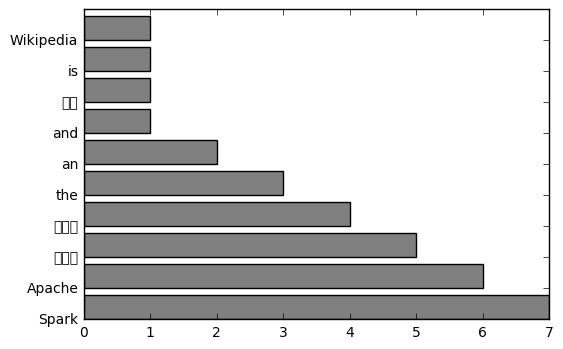

In [27]:
% matplotlib inline
import matplotlib.pyplot as plt

count = map(lambda x: x[0], wc2)
word = map(lambda x: x[1], wc2)
plt.barh(range(len(count)), count, color = 'grey')
plt.yticks(range(len(count)), word)
plt.show()

#### combineByKey

앞서 사용했던 데이터로 combineByKey()를 사용해 보자. 키별로 합계 및 갯수 ```(key, (sum, count))```를 계산한다.

구분 | combiner | merge values | merge combiner
-----|-----|-----|-----
설명 | 각 키에 대해 **```(value,1)```** 튜플 만든다 | 값을 더해나감 (sum,count)<br>즉, **```sum+value```**,**```count+1```** | combiner를 더함 key,(sum,count)
예제 | key1,(1,1) | 다음 신규 데이터 (key1,1)을 추가해서 key1,(1+1,1+1) | key1,(5,5)
결과 | key1,(1,1)<br>key1,(1,1)<br>key1,(1,1)<br>key1,(1,1)<br>key1,(1,1)<br>key1,(1,1)<br>key2,(1,1)<br>key2,(1,1)<br>key2,(1,1)<br>key2,(1,1)<br>key2,(1,1) | (5,5)<br>(6,6) | key1,(5,5)<br>key2,(6,6)

In [9]:
_testRdd.combineByKey(lambda value: (value,1),
                     lambda x,value: (x[0]+value, x[1]+1),
                     lambda x,y: (x[0]+y[0], x[1]+y[1])) \
        .collect()

[('key2', (5, 5)), ('key1', (6, 6))]

* 평균 구하기

In [10]:
_testCbkRdd=_testRdd.combineByKey(lambda value: (value,1),
                     lambda x,value: (x[0]+value, x[1]+1),                      
                     lambda x,y: (x[0]+y[0], x[1]+y[1]))

In [11]:
averageByKey = _testCbkRdd.map(lambda (key,(sum,count)):(key,float(sum)/count))
averageByKey.collectAsMap()

{'key1': 1.0, 'key2': 1.0}

#### combineByKey 예제

* combineByKey(x, y, z) - groupByKey()는 값 합계를 미리 계산하지 때문에 비효율적이다.
* partition별로 무작위 배분되어 실행되나, 아래는 하나의 partition을 가정하고 예제를 설명한다.
    * partition A: ('kim',86),('lim',87),('kim',91),('lim',79)
    * partition B: ('kim',75),('lim',78),('lim',92),('lee',99)

구분 | 함수명 | 설명
-----|-----|-----
x | Combiner 함수 | 값을 combine (V) -> C 예: (value,1)
y | Merge value 함수 | 값을 merge (C, V) -> C 예: (sum,count)
z | Merge combiners 함수 | combiner를 merge (C, C) -> C) 예: (K, C)

데이터 | 적용 함수 | 결과
-----|-----|-----
('kim',86) | combiner | accum[kim],(86,1)
('lim',87) | combiner | accum[lim],(87,1)
('kim',75) | merge value | (accum[kim],75) -> accum[kim],(86+75,1+1) = (161,2)
('kim',91) | merge value | (accum[kim],91) -> (161+91,2+1) = (252,3)
('lim',78) | merge value | (accum[lim],78) -> (87+78,1+1) = (165,2)
('lim',92) | merge value | (accum[lim],92) -> (165+92,2+1) = (257,3)
('lim',79) | merge value | (accum[lim],79) -> (257+79,3+1) = (336,4)
('lee',99) | combiner | accum[lee],(99,1)
최종적으로 | merge combiners | [('lim', (336, 4)), ('lee', (99, 1)), ('kim', (252, 3))


In [18]:
marks = spark.sparkContext.parallelize([('kim',86),('lim',87),('kim',75),
                                      ('kim',91),('lim',78),('lim',92),
                                      ('lim',79),('lee',99)])
marksByKey = marks.combineByKey(lambda value: (value,1),
                             lambda x,value: (x[0]+value, x[1]+1),
                             lambda x,y: (x[0]+y[0], x[1]+y[1]))
marksByKey.collect()

[('lim', (336, 4)), ('lee', (99, 1)), ('kim', (252, 3))]

In [21]:
heights = spark.sparkContext.parallelize([
        ('M',182.),('F',164.),('M',180.),('M',185.),('M',171.),('F',162.)
    ])
heightsByKey = heights.combineByKey(lambda value: (value,1),
                             lambda x,value: (x[0]+value, x[1]+1),
                             lambda x,y: (x[0]+y[0], x[1]+y[1]))
heightsByKey.collect()

[('M', (718.0, 4)), ('F', (326.0, 2))]

In [22]:
avgByKey = heightsByKey.map(lambda (label,(valSum,count)):
                                (label,valSum/count))

print avgByKey.collectAsMap()

{'M': 179.5, 'F': 163.0}


## 문제 S-3: 성적 합계 및 평균.

이름 | 과목 | 점수
-----|-----|-----
김하나 | English | 100
김하나 | Math | 80
임하나 | English | 70
임하나 | Math | 100
김갑돌 | English | 82.3
김갑돌 | Math | 98.5

* 문제 3-1: 이름으로 합계

```python
'임하나' 170.0
'김하나' 180.0
'김갑돌' 180.8
```
* 문제 3-2: 과목으로 합계

```python
'English' 252.3
'Math' 278.5
```

* 문제 3-3: 이름으로 합계과 개수

```python
'임하나' (170.0, 2)
'김하나' (180.0, 2)
'김갑돌' (180.8, 2)
```

* 문제 3-4: 이름으로평균

```python
'임하나' 85.0
'김하나' 90.0
'김갑돌' 90.4
```


In [8]:
marks=[
    "'김하나','English', 100",
    "'김하나','Math', 80",
    "'임하나','English', 70",
    "'임하나','Math', 100",
    "'김갑돌','English', 82.3",
    "'김갑돌','Math', 98.5"
]
_marksRdd=spark.sparkContext.parallelize(marks)

In [9]:
# marks by name
_marksbyname=_marksRdd.map(lambda x:x.split(',')).map(lambda x: (x[0],float(x[2])))
for i in _marksbyname.reduceByKey(lambda x,y:x+y).collect():
  print i[0],i[1]

'임하나' 170.0
'김하나' 180.0
'김갑돌' 180.8


In [10]:
# marks by subject
_marksbysubject=_marksRdd.map(lambda x:x.split(',')).map(lambda x: (x[1],float(x[2])))
for i in _marksbysubject.reduceByKey(lambda x,y:x+y).collect():
  print i[0],i[1]

'English' 252.3
'Math' 278.5


In [11]:
# sum, counts by name
sum_counts = _marksbyname.combineByKey(
    (lambda x: (x, 1)), # the initial value, with value x and count 1
    (lambda acc, value: (acc[0]+value, acc[1]+1)), # how to combine a pair value with the accumulator: sum value, and increment count
    (lambda acc1, acc2: (acc1[0]+acc2[0], acc1[1]+acc2[1])) # combine accumulators
)

In [12]:
for i in sum_counts.collect():
    for each in i:
        print each,
    print

'임하나' (170.0, 2)
'김하나' (180.0, 2)
'김갑돌' (180.8, 2)


In [13]:
# average
averageByKey = sum_counts.map(lambda (key,(sum,count)):(key,float(sum)/count))
for i in averageByKey.collect():
    for j in i:
        print j,
    print

'임하나' 85.0
'김하나' 90.0
'김갑돌' 90.4


## 문제 S-4: 서울시 지하철호선별 승차인원 평균 구하기.

### 문제

정량데이터는 보통 집단화하여 빈도, 평균, 합계 등 서술통계를 계산한다.
서울시 지하철호선별 역별 승하차 인원 정보를 가져와 평균을 구해보자.
* 파일 명 CARD_SUBWAY_MONTH_201501.csv를 다운로드 받아서 일부만 테스트용 데이터로 사용한다.
* 오픈API 샘플URL http://openapi.seoul.go.kr:8088/(인증키)/xml/CardSubwayStatsNew/1/5/20151101

### 해결

PairRDD를 사용한다.

* 2015년 1월 csv파일의 일부를 가져와서 리스트를 생성한다.
* 데이터 헤더: "사용일자","노선명","역ID","역명",승차총승객수,하차총승객수

In [7]:
_sub=["20150101,2호선,0236,영등포구청,6199,6219",
"20150101,2호선,0237,당산,7982,8946",
"20150101,2호선,0238,합정,17406,15241",
"20150101,3호선,0309,지축,515,538",
"20150101,3호선,0310,구파발,6879,6260",
"20150101,3호선,0311,연신내,20031,19470",
"20150101,3호선,0312,불광,9519,11029",
"20150101,4호선,0425,회현,7465,7574",
"20150101,4호선,0426,서울역,3943,10823",
"20150101,경부선,1002,남영,4340,4535",
"20150101,경부선,1003,용산,28980,27684",
"20150101,경부선,1004,노량진,23021,23862",
"20150101,경부선,1005,대방,6360,6476",
"20150101,경부선,1006,영등포,37247,36102",
"20150101,경원선,1008,이촌,1940,1507",
"20150101,경원선,1009,서빙고,911,1000",
"20150101,경원선,1010,한남,1885,1863",
"20150101,경원선,1011,옥수,43,37"]


In [8]:
_subRdd = spark.sparkContext.parallelize(_sub)

In [10]:
for i in _subRdd.take(1):
    print i,

20150101,2호선,0236,영등포구청,6199,6219


* map()을 사용해서 컴마를 제외할 수 있다.

In [13]:
for i in _subRdd.map(lambda x:x.split(',')).collect():
    for j in i:
        print j,
    print

20150101 2호선 0236 영등포구청 6199 6219
20150101 2호선 0237 당산 7982 8946
20150101 2호선 0238 합정 17406 15241
20150101 3호선 0309 지축 515 538
20150101 3호선 0310 구파발 6879 6260
20150101 3호선 0311 연신내 20031 19470
20150101 3호선 0312 불광 9519 11029
20150101 4호선 0425 회현 7465 7574
20150101 4호선 0426 서울역 3943 10823
20150101 경부선 1002 남영 4340 4535
20150101 경부선 1003 용산 28980 27684
20150101 경부선 1004 노량진 23021 23862
20150101 경부선 1005 대방 6360 6476
20150101 경부선 1006 영등포 37247 36102
20150101 경원선 1008 이촌 1940 1507
20150101 경원선 1009 서빙고 911 1000
20150101 경원선 1010 한남 1885 1863
20150101 경원선 1011 옥수 43 37


* 호선별 데이터 개수를 출력해 본다.
* map()의 3번째 인덱스는 앞에서부터 4번째 철자를 출력한다.
* 컴마로 분리해서 인덱스를 사용해야 제대로 데이터를 출력한다.

In [26]:
_subRdd.map(lambda x:int(x[3])).collect()

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

In [28]:
_subRdd.map(lambda x:x.split(',')).map(lambda x:int(x[4])).collect()

[6199,
 7982,
 17406,
 515,
 6879,
 20031,
 9519,
 7465,
 3943,
 4340,
 28980,
 23021,
 6360,
 37247,
 1940,
 911,
 1885,
 43]

* 총 승차인원의 합계를 reduce()로 합산한다.
* reduce()함수는 인자를 2개 받아서 합계를 구한다.

In [37]:
_subRdd.map(lambda x:x.split(',')).map(lambda x:(int(x[4]))).reduce(lambda x,y:x+y)

184666

* 호선별 승차인원 평균을 계산한다.
* Pair RDD를 사용하므로, 사전에 데이터를 (호선, 승차인원) 형식으로 구성한다.

In [ ]:
_subLineByPassengers=_subRdd.map(lambda x:x.split(',')).map(lambda x: (x[1],int(x[4])))
sum_counts = _subLineByPassengers.combineByKey(
    (lambda x: (x, 1)), # the initial value, with value x and count 1
    (lambda acc, value: (acc[0]+value, acc[1]+1)), # how to combine a pair value with the accumulator: sum value, and increment count
    (lambda acc1, acc2: (acc1[0]+acc2[0], acc1[1]+acc2[1])) # combine accumulators
)

In [39]:
for i in sum_counts.collect():
    for each in i:
        print each,
    print

4호선 (11408, 2)
2호선 (31587, 3)
경원선 (4779, 4)
3호선 (36944, 4)
경부선 (99948, 5)


In [44]:
for i in sum_counts.collect():
    print i[0],i[1][0],i[1][1]

4호선 11408 2
2호선 31587 3
경원선 4779 4
3호선 36944 4
경부선 99948 5


* 위와 달리 map()을 사용하여 평균을 계산한다.

In [ ]:
averageByKey = sum_counts.map(lambda (key,(sum,count)):(key,float(sum)/count))

In [45]:
averageByKey.collectAsMap()

{'2\xed\x98\xb8\xec\x84\xa0': 10529.0,
 '3\xed\x98\xb8\xec\x84\xa0': 9236.0,
 '4\xed\x98\xb8\xec\x84\xa0': 5704.0,
 '\xea\xb2\xbd\xeb\xb6\x80\xec\x84\xa0': 19989.6,
 '\xea\xb2\xbd\xec\x9b\x90\xec\x84\xa0': 1194.75}

In [51]:
for i in averageByKey.collect():
    for j in i:
        print j,
    print

4호선 5704.0
2호선 10529.0
경원선 1194.75
3호선 9236.0
경부선 19989.6


## S.7 spark-submit

* sys.path 설정은 하지 않아도 된다.

* spark-submit을 실행하기 전, 'conf/log4j.properties'를 수정 log level을 ERROR로 설정하였다.
```
log4j.rootCategory=ERROR, console
```

* Python 파일의 encoding 선언
    * 기본 설정은 7-bit ASCII
```
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
```

In [8]:
%%writefile src/ds_spark_rdd_hello.py
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
import pyspark
def doIt():
    print "---------RESULT-----------"
    print spark.version
    spark.conf.set("spark.logConf","false")
    rdd=spark.sparkContext.parallelize(range(1000), 10)
    print "mean=",rdd.mean()
    nums = spark.sparkContext.parallelize([1, 2, 3, 4])
    squared = nums.map(lambda x: x * x).collect()
    for num in squared:
        print "%i " % (num)

if __name__ == "__main__":
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()
    doIt()
    spark.stop()


Overwriting src/ds_spark_rdd_hello.py


In [24]:
!/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/bin/spark-submit src/ds_spark_rdd_hello.py

Ivy Default Cache set to: /home/jsl/.ivy2/cache
The jars for the packages stored in: /home/jsl/.ivy2/jars
:: loading settings :: url = jar:file:/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
graphframes#graphframes added as a dependency
org.mongodb.spark#mongo-spark-connector_2.10 added as a dependency
com.databricks#spark-csv_2.11 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent;1.0
	confs: [default]
	found graphframes#graphframes;0.4.0-spark2.0-s_2.11 in spark-packages
	found com.typesafe.scala-logging#scala-logging-api_2.11;2.1.2 in central
	found com.typesafe.scala-logging#scala-logging-slf4j_2.11;2.1.2 in central
	found org.scala-lang#scala-reflect;2.11.0 in central
	found org.slf4j#slf4j-api;1.7.7 in central
	found org.mongodb.spark#mongo-spark-connector_2.10;2.0.0 in central
	found org.mongodb#mongo-java-driver;3.2.2 in central
	found com.databricks#spark-csv_2.11;1.5.0 in cent

In [22]:
%%writefile src/ds_spark_rdd_reduceBykey.py
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
import pyspark
import os
def doIt():
    print "---------RESULT-----------"
    myRdd=spark.sparkContext\
        .textFile(os.path.join("data","ds_spark_wiki.txt"))
    res=myRdd\
        .flatMap(lambda x:x.split())\
        .map(lambda x:(x,1))\
        .reduceByKey(lambda x,y:x+y)\
        .map(lambda x:(x[1],x[0]))\
        .sortByKey(False)\
        .take(10)
    for i in res:
        print i

if __name__ == "__main__":
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()
    doIt()
    spark.stop()


Overwriting src/ds_spark_rdd_reduceBykey.py


In [23]:
!/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/bin/spark-submit src/ds_spark_rdd_reduceBykey.py

Ivy Default Cache set to: /home/jsl/.ivy2/cache
The jars for the packages stored in: /home/jsl/.ivy2/jars
:: loading settings :: url = jar:file:/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
graphframes#graphframes added as a dependency
org.mongodb.spark#mongo-spark-connector_2.10 added as a dependency
com.databricks#spark-csv_2.11 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent;1.0
	confs: [default]
	found graphframes#graphframes;0.4.0-spark2.0-s_2.11 in spark-packages
	found com.typesafe.scala-logging#scala-logging-api_2.11;2.1.2 in central
	found com.typesafe.scala-logging#scala-logging-slf4j_2.11;2.1.2 in central
	found org.scala-lang#scala-reflect;2.11.0 in central
	found org.slf4j#slf4j-api;1.7.7 in central
	found org.mongodb.spark#mongo-spark-connector_2.10;2.0.0 in central
	found org.mongodb#mongo-java-driver;3.2.2 in central
	found com.databricks#spark-csv_2.11;1.5.0 in cent

## 문제 S-4: RDD를 사용하여 word vector를 생성하기.

### 문제
사람은 문서를 읽으면 그 의미를 알 수 있다. 주제가 무엇이고 심지어는 숨겨진 행간도 이해할 수 있다.
그러나 컴퓨터는 문서를 읽고 의미를 이해하는 것이 쉽지 않다.
대신 그 안에 어떤 단어가 쓰였고, 많이 쓰인 단어가 무엇인지 **word vector**를 만들어 분석하게 된다.
word vector는 단어빈도를 나타낸다.

### 해결
* RDD API를 사용해서 단어를 셀 수 있다 (map, reduce 등).
* mllib 패키지를 사용하여 데이터를 변환할 수 있다.
    * TF-IDF, Word2Vec 등을 사용할 수 있다.
    * mllib에 없는 변환기능은 ml을 사용한다 (ml은 DataFrame API 패키지.)
        * Tokenizer, Stopwords, NGram 등

### 단어별 빈도

파일 전체를 읽어서, 단어의 수를 세어 본다.
파일은 이미 만들어 놓은 wiki를 사용한다.

줄 | 설명
-----|-----
1 | sparkContext.textFile()로 파일을 읽어 RDD로 만든다.
2 | flatMap()을 으로 공백으로 분리하여 RDD를 생성한다. 이러한 변환은 실제 연산까지 일어나지 않는다, 즉 lazy변환이다.

In [4]:
!ls data/ds_spark_wiki.txt

data/ds_spark_wiki.txt


In [5]:
import os
lines=spark.sparkContext.textFile(os.path.join("data","ds_spark_wiki.txt"))
wc=lines\
    .flatMap(lambda x: x.split(' '))
print type(wc)

<class 'pyspark.rdd.PipelinedRDD'>


공백으로 분리된 RDD를 collect()함수로 취합한다.
단어의 갯수는 count() 함수로 알 수 있다.
**collect() 결과는 list**로 만들어 진다.
모든 항목을 출력하려면 list의 인덱스 [:]를 사용한다.

In [14]:
print "단어 갯수: ", wc.count()
print "전체 단어: ", wc.collect()[0:72]

단어 갯수:  72
전체 단어:  [u'Wikipedia', u'Apache', u'Spark', u'is', u'an', u'open', u'source', u'cluster', u'computing', u'framework.', u'\uc544\ud30c\uce58', u'\uc2a4\ud30c\ud06c\ub294', u'\uc624\ud508', u'\uc18c\uc2a4', u'\ud074\ub7ec\uc2a4\ud130', u'\ucef4\ud4e8\ud305', u'\ud504\ub808\uc784\uc6cc\ud06c\uc774\ub2e4.', u'Apache', u'Spark', u'Apache', u'Spark', u'Apache', u'Spark', u'Apache', u'Spark', u'\uc544\ud30c\uce58', u'\uc2a4\ud30c\ud06c', u'\uc544\ud30c\uce58', u'\uc2a4\ud30c\ud06c', u'\uc544\ud30c\uce58', u'\uc2a4\ud30c\ud06c', u'\uc544\ud30c\uce58', u'\uc2a4\ud30c\ud06c', u'Originally', u'developed', u'at', u'the', u'University', u'of', u'California,', u"Berkeley's", u'AMPLab,', u'the', u'Spark', u'codebase', u'was', u'later', u'donated', u'to', u'the', u'Apache', u'Software', u'Foundation,', u'which', u'has', u'maintained', u'it', u'since.', u'Spark', u'provides', u'an', u'interface', u'for', u'programming', u'entire', u'clusters', u'with', u'implicit', u'data', u'parallelism', u

위에서 한글이 unicode로 출력되는 것은 깨진 것이 아니다. 하나씩 출력하면 한글로 출력된다.
10번째를 출력하려면 [10], 한글이 잘 출력된다.

In [8]:
print "---> 한글로 출력:",wc.collect()[10]

---> 한글로 출력: 아파치


이제 map-reduce를 같이 사용하여 단어를 세어 tuple로 만들어 보자.
flatMap()은 앞서 설명한 바와 같이 파일 텍스트를 공백으로 분리한다.
map()함수는 모든 단어에 대해 소문자로 만들고, **불필요한 구문 (new lines, commas, periods)을 제거**한 후 tuple로 만든다.
즉 **(단어, 1) 구조**로 만들어 **같은 단어는 나중에 서로 더할 수** 있게 만들어 놓는다.

In [17]:
from operator import add
wc = spark.sparkContext.textFile(os.path.join("data","ds_spark_wiki.txt"))\
    .flatMap(lambda x: x.split(' '))\
    .map(lambda x: (x.lower().rstrip().lstrip().rstrip(',').rstrip('.'), 1))

아직 단어별로 갯수를 계산하지 않았기 때문에, 모두 1인 값을 가진다.

In [18]:
wc.sortByKey().take(5)

[(u'amplab', 1), (u'an', 1), (u'an', 1), (u'and', 1), (u'apache', 1)]

### 빈도 집계

이제 단어의 갯수를 합계내어 보자. 아래 방법 모두 **동일한 결과를 산출**한다.

구분 | 설명
-----|-----
reduceByKey(add) | 'add' operator를 사용하면, 단어튜플의 수를 키별로 더할 수 있다.
groupByKey().mapValues(sum) | mapValues()를 사용하여 value의 'sum'을 계산할 수 있다.
groupByKey().map(lambda (x,iter) : (x,len(iter))) | (key,value)의 구조를 사용하여 합계를 계산할 수 있다.

### reduceByKey()

Python의 연산자 add() 함수를 사용해서 할 수 있다.
**operator.add()**는 reduce()함수의 숫자 인자 x,y를 받아서 x+y 연산을 한다.

In [19]:
from operator import add
wcReduceByKey = wc.reduceByKey(add)

In [20]:
wcReduceByKey.sortByKey().take(10)

[(u'amplab', 1),
 (u'an', 2),
 (u'and', 1),
 (u'apache', 6),
 (u'at', 1),
 (u"berkeley's", 1),
 (u'california', 1),
 (u'cluster', 1),
 (u'clusters', 1),
 (u'codebase', 1)]

### groupByKey()

groupByKey()는 단어키로 동일한 단어는 집단화한다.
집단화 하면 **PairRDD가 되고, 즉 key-value 쌍**으로 구성된다.
**mapValues()는 각 쌍의 value에 대해서 sum 연산**을 한다.

In [21]:
wcGroupByKey = wc.groupByKey().mapValues(sum)

In [22]:
wcGroupByKey.sortByKey().take(10)

[(u'amplab', 1),
 (u'an', 2),
 (u'and', 1),
 (u'apache', 6),
 (u'at', 1),
 (u"berkeley's", 1),
 (u'california', 1),
 (u'cluster', 1),
 (u'clusters', 1),
 (u'codebase', 1)]

mapValues()를 사용하지 않고 map()으로 **len()**갯수를 세어도 동일한 결과를 얻을 수 있다.
**단어별로 1개씩 만들어 놓았으므로 len()으로 세면 단어갯수의 합계**가 된다.

In [23]:
wcGroupByKey2 = wc.groupByKey().map(lambda (x,v): (x,len(v)))

In [24]:
wcGroupByKey2.sortByKey().take(10)

[(u'amplab', 1),
 (u'an', 2),
 (u'and', 1),
 (u'apache', 6),
 (u'at', 1),
 (u"berkeley's", 1),
 (u'california', 1),
 (u'cluster', 1),
 (u'clusters', 1),
 (u'codebase', 1)]

### 줄로 구분하여 단어 빈도

flatMap()을 사용하지 않으면 줄로 구분하여 단어의 빈도를 셀 수 있다.

줄 | 설명
-----|-----
1 | sparkContext.textFile() 파일을 읽어 RDD 생성
2 | 불필요한 컴마, 점, 하이픈을 제거하고 소문자로
3 | 공백으로 분리
4 | 반복문으로 단어별 튜플구조화

In [25]:
wc = spark.sparkContext.textFile("data/ds_spark_wiki.txt")\
    .map(lambda x: x.replace(',',' ').replace('.',' ').replace('-',' ').lower())\
    .map(lambda x:x.split())\
    .map(lambda x:[(i,1) for i in x])

In [27]:
for e in wc.collect():
    print e

[(u'wikipedia', 1)]
[(u'apache', 1), (u'spark', 1), (u'is', 1), (u'an', 1), (u'open', 1), (u'source', 1), (u'cluster', 1), (u'computing', 1), (u'framework', 1)]
[(u'\uc544\ud30c\uce58', 1), (u'\uc2a4\ud30c\ud06c\ub294', 1), (u'\uc624\ud508', 1), (u'\uc18c\uc2a4', 1), (u'\ud074\ub7ec\uc2a4\ud130', 1), (u'\ucef4\ud4e8\ud305', 1), (u'\ud504\ub808\uc784\uc6cc\ud06c\uc774\ub2e4', 1)]
[(u'apache', 1), (u'spark', 1), (u'apache', 1), (u'spark', 1), (u'apache', 1), (u'spark', 1), (u'apache', 1), (u'spark', 1)]
[(u'\uc544\ud30c\uce58', 1), (u'\uc2a4\ud30c\ud06c', 1), (u'\uc544\ud30c\uce58', 1), (u'\uc2a4\ud30c\ud06c', 1), (u'\uc544\ud30c\uce58', 1), (u'\uc2a4\ud30c\ud06c', 1), (u'\uc544\ud30c\uce58', 1), (u'\uc2a4\ud30c\ud06c', 1)]
[(u'originally', 1), (u'developed', 1), (u'at', 1), (u'the', 1), (u'university', 1), (u'of', 1), (u'california', 1), (u"berkeley's", 1), (u'amplab', 1)]
[(u'the', 1), (u'spark', 1), (u'codebase', 1), (u'was', 1), (u'later', 1), (u'donated', 1), (u'to', 1), (u'the', 1)

### TF (Term Frequency)

* HashingTF: 단어ID로 Hash 값을 사용하여 단어빈도를 생성한다.

In [28]:
documents = spark.sparkContext.textFile("data/ds_spark_wiki.txt")\
    .map(lambda line: line.split(" "))

In [29]:
from pyspark.mllib.feature import HashingTF

hashingTF = HashingTF()
tf = hashingTF.transform(documents)
tf.collect()

[SparseVector(1048576, {253068: 1.0}),
 SparseVector(1048576, {36751: 1.0, 50570: 1.0, 68380: 1.0, 415281: 1.0, 511377: 1.0, 728364: 1.0, 862087: 1.0, 938426: 1.0, 999480: 1.0}),
 SparseVector(1048576, {63234: 1.0, 340190: 1.0, 357478: 1.0, 375592: 1.0, 458138: 1.0, 486171: 1.0, 598772: 1.0}),
 SparseVector(1048576, {938426: 4.0, 999480: 4.0}),
 SparseVector(1048576, {486171: 4.0, 1016271: 4.0}),
 SparseVector(1048576, {36757: 1.0, 225801: 1.0, 323305: 1.0, 453405: 1.0, 498679: 1.0, 518030: 1.0, 688842: 1.0, 762570: 1.0, 959994: 1.0}),
 SparseVector(1048576, {420843: 1.0, 550676: 1.0, 725041: 1.0, 782544: 1.0, 938426: 1.0, 959994: 2.0, 991590: 1.0, 993084: 1.0, 996703: 1.0, 999480: 1.0}),
 SparseVector(1048576, {50573: 1.0, 263739: 1.0, 892834: 1.0, 1014710: 1.0, 1035538: 1.0}),
 SparseVector(1048576, {3932: 1.0, 36751: 1.0, 192182: 1.0, 358969: 1.0, 363244: 1.0, 496856: 1.0, 546913: 1.0, 938426: 1.0, 951974: 1.0}),
 SparseVector(1048576, {69621: 1.0, 157580: 1.0, 219357: 1.0, 297436: 